<a href="https://colab.research.google.com/github/FatherOfLove/AdvancedDeepLearning/blob/master/Assignment7_extra_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part A XGBOOST**

In [1]:
import sys
python_version = sys.version_info[0]

In [2]:
# If you're running on Colab, you'll need to install the What-if Tool package and authenticate
# If you're on Cloud AI Platform Notebooks, you'll need to install XGBoost on the TF instance
def pip_install(module):
    if python_version == '2':
        !pip install {module} --quiet
    else:
        !pip3 install {module} --quiet

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    pip_install('witwidget')

    from google.colab import auth
    auth.authenticate_user()
else:
    pip_install('xgboost')

     |████████████████████████████████| 2.3MB 3.7MB/s 


In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [4]:
# Use a small subset of the data since the original dataset is too big for Colab (2.5GB)
# Data source: https://www.ffiec.gov/hmda/hmdaflat.htm
!gsutil cp gs://mortgage_dataset_files/mortgage-small.csv .

Copying gs://mortgage_dataset_files/mortgage-small.csv...
/ [1 files][330.8 MiB/330.8 MiB]                                                
Operation completed over 1 objects/330.8 MiB.                                    


In [5]:
# Set column dtypes for Pandas
COLUMN_NAMES = collections.OrderedDict({
  'as_of_year': np.int16,
  'agency_code': 'category',
  'loan_type': 'category',
  'property_type': 'category',
  'loan_purpose': 'category',
  'occupancy': np.int8,
  'loan_amt_thousands': np.float64,
  'preapproval': 'category',
  'county_code': np.float64,
  'applicant_income_thousands': np.float64,
  'purchaser_type': 'category',
  'hoepa_status': 'category',
  'lien_status': 'category',
  'population': np.float64,
  'ffiec_median_fam_income': np.float64,
  'tract_to_msa_income_pct': np.float64,
  'num_owner_occupied_units': np.float64,
  'num_1_to_4_family_units': np.float64,
  'approved': np.int8
})

In [6]:
# Load data into Pandas
data = pd.read_csv(
  'mortgage-small.csv', 
  index_col=False,
  dtype=COLUMN_NAMES
)
data = data.dropna()
data = shuffle(data, random_state=2)
data.head()

as_of_year  ... approved
310650        2016  ...        1
630129        2016  ...        0
715484        2016  ...        1
887708        2016  ...        1
719598        2016  ...        1

[5 rows x 19 columns]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999999 entries, 310650 to 875688
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   as_of_year                  999999 non-null  int16   
 1   agency_code                 999999 non-null  category
 2   loan_type                   999999 non-null  category
 3   property_type               999999 non-null  category
 4   loan_purpose                999999 non-null  category
 5   occupancy                   999999 non-null  int8    
 6   loan_amt_thousands          999999 non-null  float64 
 7   preapproval                 999999 non-null  category
 8   county_code                 999999 non-null  float64 
 9   applicant_income_thousands  999999 non-null  float64 
 10  purchaser_type              999999 non-null  category
 11  hoepa_status                999999 non-null  category
 12  lien_status                 999999 non-null  category

In [8]:
data.tail()

as_of_year  ... approved
437782        2016  ...        1
620104        2016  ...        1
203245        2016  ...        1
100879        2016  ...        0
875688        2016  ...        1

[5 rows x 19 columns]

In [9]:
data.isnull().value_counts()

as_of_year  agency_code  loan_type  property_type  loan_purpose  occupancy  loan_amt_thousands  preapproval  county_code  applicant_income_thousands  purchaser_type  hoepa_status  lien_status  population  ffiec_median_fam_income  tract_to_msa_income_pct  num_owner_occupied_units  num_1_to_4_family_units  approved
False       False        False      False          False         False      False               False        False        False                       False           False         False        False       False                    False                    False                     False                    False       999999
dtype: int64

In [10]:
# Label preprocessing
labels = data['approved'].values

# See the distribution of approved / denied classes (0: denied, 1: approved)
print(data['approved'].value_counts())

1    665389
0    334610
Name: approved, dtype: int64


In [11]:
data = data.drop(columns=['approved'])

In [12]:
data.head()

as_of_year  ... num_1_to_4_family_units
310650        2016  ...                  1631.0
630129        2016  ...                  1450.0
715484        2016  ...                  1076.0
887708        2016  ...                  1666.0
719598        2016  ...                  1006.0

[5 rows x 18 columns]

In [13]:
# Convert categorical columns to dummy columns
dummy_columns = list(data.dtypes[data.dtypes == 'category'].index)
data = pd.get_dummies(data, columns=dummy_columns)

In [14]:
data.head()

as_of_year  ...  lien_status_Secured by a subordinate lien
310650        2016  ...                                          0
630129        2016  ...                                          0
715484        2016  ...                                          0
887708        2016  ...                                          1
719598        2016  ...                                          0

[5 rows x 44 columns]

In [15]:
# Split the data into train / test sets
x,y = data,labels
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.01, random_state=42)

In [16]:
# Train the model, this will take a few minutes to run
bst = xgb.XGBClassifier(
    objective='reg:logistic'
)

In [17]:
bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
# Get predictions on the test set and print the accuracy score
y_pred = bst.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print(acc, '\n')

0.8663969696969697 



**result**

In [19]:
# Print a confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred.round())
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

Confusion matrix:
[[0.83721492 0.08189339]
 [0.23638981 0.88107778]]


# **Part B CatBoost**

In [20]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 66.3MB 43kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [74]:
from catboost.datasets import titanic
import numpy as np

train_df, test_df = titanic()

train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [75]:
null_value_stats = train_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [76]:
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

In [77]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

In [78]:
print(X.dtypes)

categorical_features_indices = np.where(X.dtypes != np.float)[0]

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [79]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_df

In [80]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [81]:
model1 = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [82]:
model1.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [84]:
cv_params = model1.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Result**

In [31]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.83±0.02 on step 543


In [32]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8260381593714928


# **Part C LightGBM**

In [33]:
# After running
! git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;   

Cloning into 'LightGBM'...
remote: Enumerating objects: 20455, done.
remote: Total 20455 (delta 0), reused 0 (delta 0), pack-reused 20455
Receiving objects: 100% (20455/20455), 16.06 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (14924/14924), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Cloning into '/content/LightGBM/external_libs/fast_double_parser'...
remote: Enumerating objects: 126, done

In [34]:
URL_calendar = "https://slavadatasets.s3.us-east-2.amazonaws.com/calendar.csv"
URL_sales_train ='https://slavadatasets.s3.us-east-2.amazonaws.com/sales_train_validation.csv'
URL_prices = 'https://slavadatasets.s3.us-east-2.amazonaws.com/sell_prices.csv' 

In [39]:
%pip install "dask[complete]"    

     |████████████████████████████████| 92kB 3.7MB/s 
     |████████████████████████████████| 675kB 21.7MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=b4fd923aa23918c2dcd3dacc466c7073c68acb13e0587c1b2be9ff7ba77fd182
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4041 sha256=7db0bd28f91e1642d1740538ea69a013993fa205cfa9066575767259732de103
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: distributed 2020.12.0 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2020.12.0 has requirement dask>=2020.12.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distribu

In [49]:
%pip install argopy

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 4.3MB 8.4MB/s 
     |████████████████████████████████| 2.4MB 55.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 296kB 56.3MB/s 


In [53]:
%pip install aiohttp

     |████████████████████████████████| 1.3MB 6.0MB/s 
     |████████████████████████████████| 296kB 55.6MB/s 
     |████████████████████████████████| 143kB 50.5MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=dee76cf353441b79802f6404100250df97f81f268800a751ea87d4252913c019
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [54]:
from  datetime import datetime, timedelta
import numpy as np, pandas as pd
import gc
import io
import dask.dataframe as dd
import lightgbm as lgb
import argopy
import aiohttp

In [55]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [56]:
pd.options.display.max_columns = 50

In [57]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
     
    prices = dd.read_csv(URL_prices,dtype = PRICE_DTYPES).compute()
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
        
    cal = dd.read_csv(URL_calendar,dtype = CAL_DTYPES).compute()
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = dd.read_csv(URL_sales_train, 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype).compute()
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [58]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [59]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [60]:
# If you want to load all the data set it to '1' -->  Great  memory overflow  risk ! default= 350
FIRST_DAY = 1300


In [62]:
df = train_df

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [64]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
    
    'device' : 'gpu',
    'verbosity': 1,
    #'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_df

In [66]:
model = lgb.LGBMRegressor(**params)
model

LGBMRegressor(bagging_freq=1, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, device='gpu', force_row_wise=True,
              importance_type='split', lambda_l2=0.1, learning_rate=0.075,
              max_depth=-1, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=100, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=128, objective='poisson',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              sub_row=0.75, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbosity=1)

In [88]:
m_lgb = model1.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [89]:
cv_params = m_lgb.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [90]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.83±0.02 on step 543


# ***Part D do a simple colab with detailed visualization of results***

In [91]:
%pip install -q statsmodels

In [92]:
import numpy as np
import pandas as pd
from IPython.display import clear_output

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [93]:
import tensorflow as tf
tf.random.set_seed(123)

In [94]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [95]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [96]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

0
accuracy                0.803030
accuracy_baseline       0.625000
auc                     0.869483
auc_precision_recall    0.851343
average_loss            0.416908
label/mean              0.375000
loss                    0.416908
precision               0.752688
prediction/mean         0.386508
recall                  0.707071
global_step           100.000000

In [97]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3at4_8wl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [99]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3at4_8wl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [100]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

count      mean       std       min       25%       50%  \
age                 264.0 -0.025980  0.093778 -0.147969 -0.077102 -0.054172   
sex                 264.0  0.006559  0.107806 -0.097792 -0.074628 -0.072858   
class               264.0  0.016631  0.093784 -0.162675 -0.043060 -0.041724   
deck                264.0 -0.018093  0.032575 -0.094638 -0.042912 -0.032754   
embark_town         264.0 -0.007017  0.031436 -0.056042 -0.017526 -0.015517   
fare                264.0  0.027026  0.089513 -0.224306 -0.028076 -0.002334   
n_siblings_spouses  264.0  0.001434  0.025849 -0.133110  0.002419  0.003337   
parch               264.0  0.000019  0.011432 -0.098722  0.000654  0.000864   
alone               264.0  0.000000  0.000000  0.000000  0.000000  0.000000   

                         75%       max  
age                 0.004607  0.505813  
sex                 0.138226  0.182456  
class               0.033055  0.226018  
deck                0.001897  0.199893  
embark_town        -0.003948  0.086491  
fare                0.072627  0.285098  
n_siblings_spouses  0.006167  0.103482  
parch               0.001482  0.040270  
alone               0.000000  0.000000

In [101]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

In [102]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

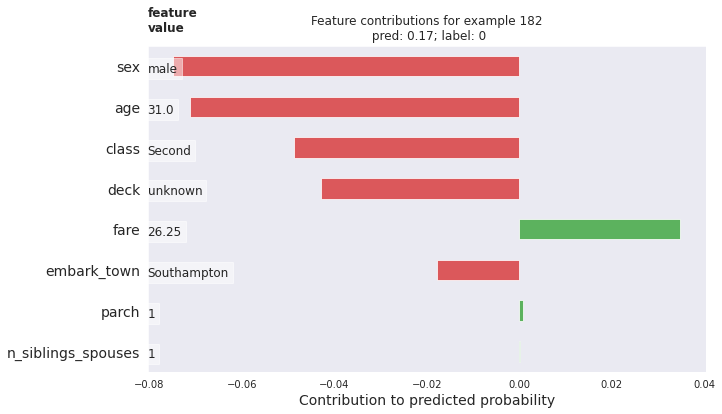

In [103]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [104]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)

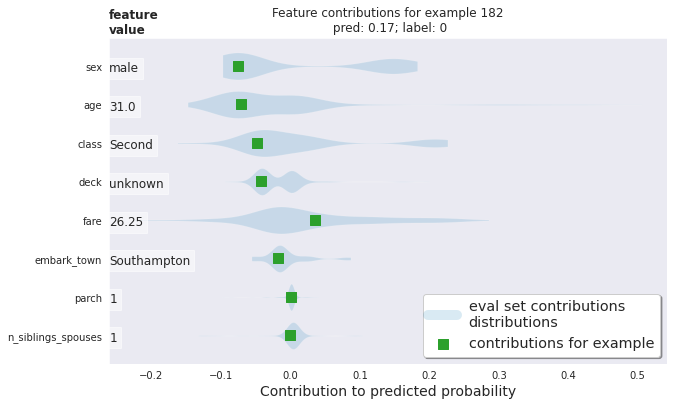

In [105]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

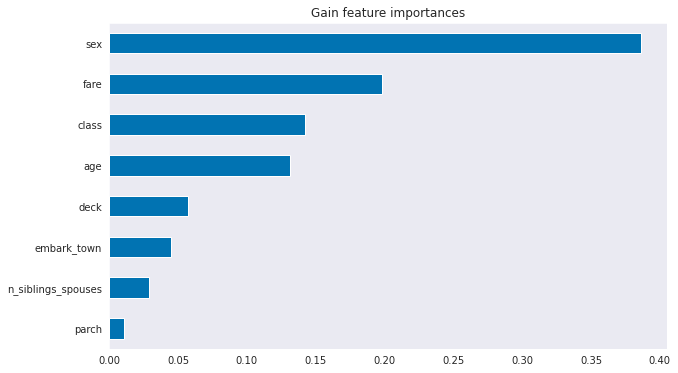

In [106]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

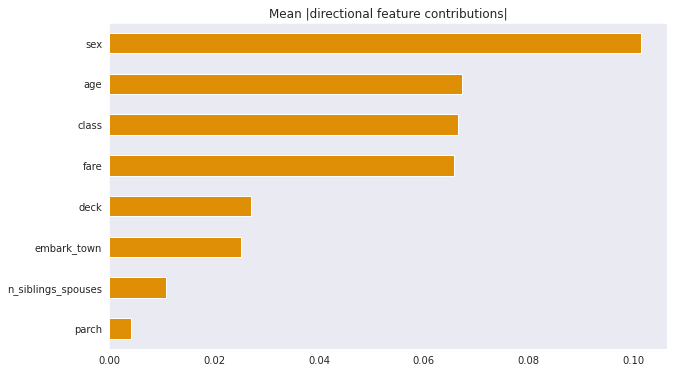

In [107]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


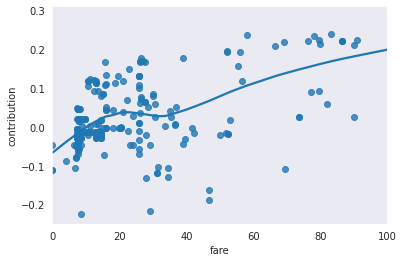

In [108]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

In [109]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-15T07:23:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3at4_8wl/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.62710s
INFO:tensorflow:Finished evaluation at 2020-12-15-07:23:24
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.81439394, accuracy_baseline = 0.625, auc = 0.86853385, auc_precision_recall = 0.8522887, average_loss = 0.4158357, global_step = 153, label/mean = 0.375, loss = 0.4158357, precision = 0.7604167, prediction/mean = 0.38813925, recall = 0.7373737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmp3at4_8wl/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-15T07:23:25Z
INFO:tensorflow:Graph was final

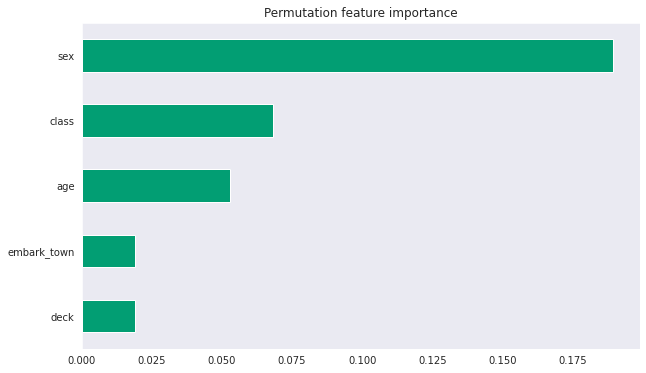

In [110]:
def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']
features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

In [111]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
xy = np.zeros((2,np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [112]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [113]:
def plot_contour(x, y, z, **kwargs):
  # Grid the data.
  plt.figure(figsize=(10, 8))
  # Contour the gridded data, plotting dots at the nonuniform data points.
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()  # Draw colorbar.
  # Plot data points.
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

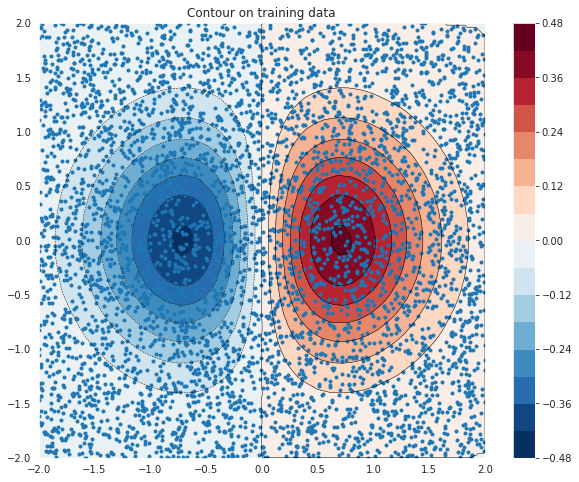

In [114]:
zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [115]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [116]:
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

In [117]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpb7z6796b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructio

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpb7z6796b/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


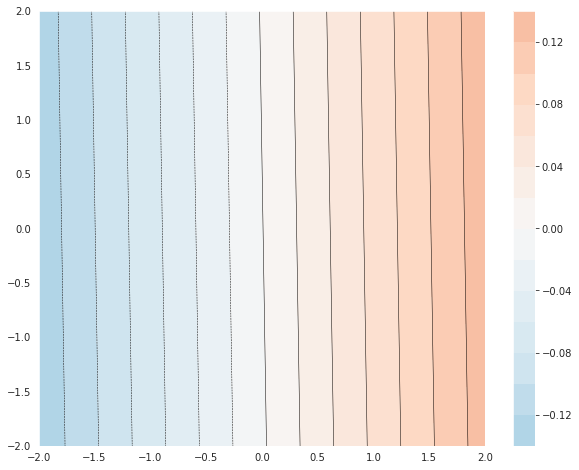

In [118]:
plot_contour(xi, yi, predict(est))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpauwbizpx/model.ckpt-222
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


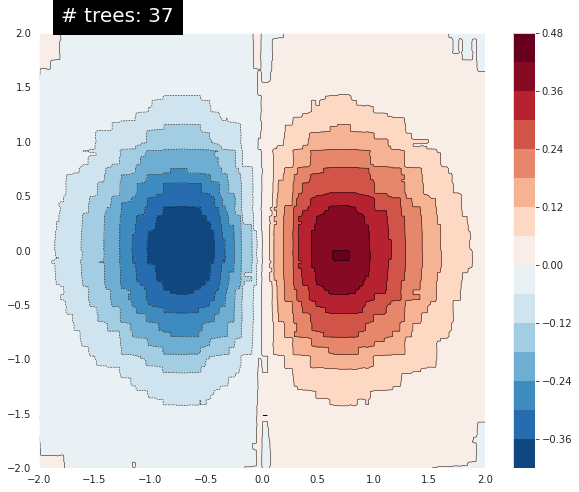

In [119]:
n_trees = 37

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()